<a href="https://colab.research.google.com/github/KimRass/Programming/blob/master/Data%20Science/Machine%20Learning/Computer%20Vision/Selective%20Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Data Science/Machine Learning/Computer Vision/Selective Search.ipynb

from google.colab import drive
import os
drive.mount("/content/drive")
os.chdir("/content")

import sys
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Layer, Dense, Flatten, Dropout, Concatenate, Add, Dot, Multiply, Reshape, Activation, BatchNormalization, SimpleRNNCell, RNN, SimpleRNN, LSTM, Embedding, Bidirectional, TimeDistributed, Conv1D, Conv2D, MaxPool1D, MaxPool2D, GlobalMaxPool1D, GlobalMaxPool2D, AveragePooling1D, AveragePooling2D, GlobalAveragePooling1D, GlobalAveragePooling2D, ZeroPadding2D
from tensorflow.keras.optimizers import SGD, Adam, Adagrad
from tensorflow.keras.metrics import MeanSquaredError, RootMeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError, BinaryCrossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy, CosineSimilarity
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.activations import linear, sigmoid, relu
from tensorflow.keras.initializers import RandomNormal, glorot_uniform, he_uniform, Constant
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

os.chdir("/content/drive/MyDrive/Libraries")
from selectivesearch import selective_search
os.chdir("/content")

plt.style.use("dark_background")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


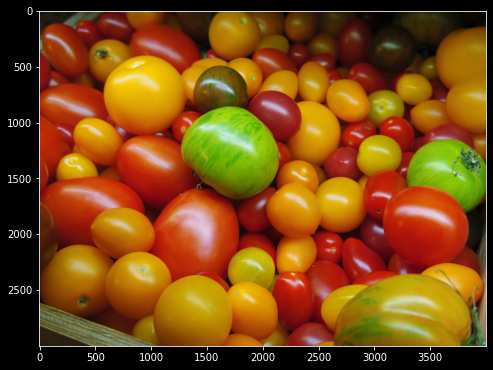

In [ ]:
os.chdir("/content/drive/MyDrive/CV")

img = cv2.imread("bod_mainImg_01.jpg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 8))
plt.imshow(img_rgb);

In [ ]:
_, regions = selective_search(img_rgb, scale=100, min_size=2000)

In [ ]:
regions[:10]

[{'labels': [0.0], 'rect': (0, 0, 340, 211), 'size': 33747},
 {'labels': [1.0], 'rect': (0, 0, 371, 437), 'size': 26932},
 {'labels': [2.0], 'rect': (117, 0, 373, 148), 'size': 16098},
 {'labels': [3.0], 'rect': (386, 0, 266, 129), 'size': 13512},
 {'labels': [4.0], 'rect': (33, 0, 847, 723), 'size': 309755},
 {'labels': [5.0], 'rect': (756, 0, 141, 385), 'size': 8347},
 {'labels': [6.0], 'rect': (790, 0, 810, 561), 'size': 252379},
 {'labels': [7.0], 'rect': (1508, 0, 110, 290), 'size': 3347},
 {'labels': [8.0], 'rect': (1524, 0, 135, 284), 'size': 2495},
 {'labels': [9.0], 'rect': (1530, 0, 716, 431), 'size': 226917}]

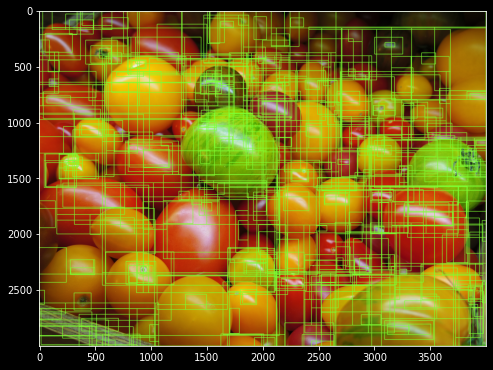

In [ ]:
cand_rects = [i["rect"] for i in regions]

rgb_green = (125, 255, 51)
img_rects = img_rgb.copy()
for rect in cand_rects:   
    cv2.rectangle(img=img_rects, pt1=(rect[0], rect[1]), pt2=(rect[0] + rect[2], rect[1] + rect[3]), color=rgb_green, thickness=4)
    
plt.figure(figsize=(8, 8))
plt.imshow(img_rects);

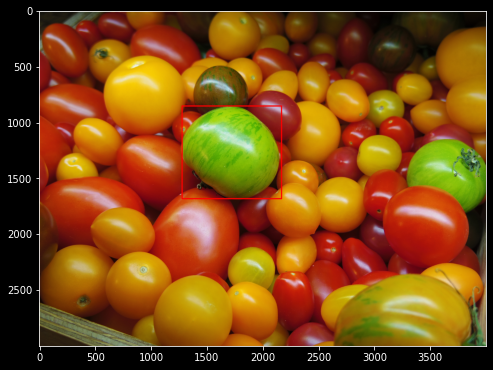

In [ ]:
gt_bbox = [1280, 850, 2170, 1680]
rgb_red = (255, 0 , 0)
img_gt = img_rgb.copy()
cv2.rectangle(img=img_gt, pt1=(gt_bbox[0], gt_bbox[1]), pt2=(gt_bbox[2], gt_bbox[3]), color=rgb_red, thickness=10)

plt.figure(figsize=(8, 8))
plt.imshow(img_gt);

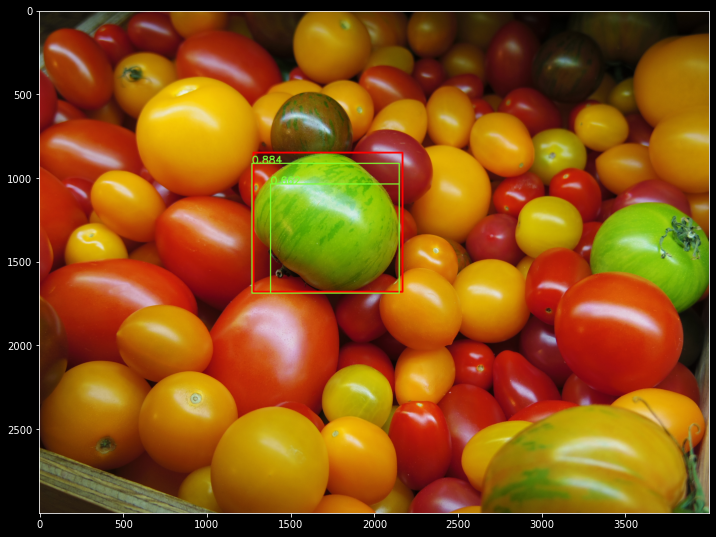

In [ ]:
def giou(bbox1, bbox2):
		# (x1, y1, x2, y2)
		bbox1 = np.array(bbox1)
		bbox2 = np.array(bbox2)

		area_bbox1 = (bbox1[2] - bbox1[0])*(bbox1[3] - bbox1[1])
		area_bbox2 = (bbox2[2] - bbox2[0])*(bbox2[3] - bbox2[1])

		pt1_intsec = np.maximum(bbox1[:2], bbox2[:2])
		pt2_intsec = np.minimum(bbox1[2:], bbox2[2:])
		w_intsec, h_intsec = np.maximum(pt2_intsec - pt1_intsec, 0)
		area_intsec = w_intsec*h_intsec

		area_union = area_bbox1 + area_bbox2 - area_intsec

		iou = np.maximum(area_intsec/area_union, np.finfo(np.float32).eps)

		pt1_enclosed = np.minimum(bbox1[:2], bbox2[:2])
		pt2_enclosed = np.maximum(bbox1[2:], bbox2[2:])
		w_enclosed, h_enclosed = np.maximum(pt2_enclosed - pt1_enclosed, 0)
		area_enclosed = w_enclosed*h_enclosed

		return iou - (area_enclosed - area_union)/area_enclosed

img_gt_rects = img_gt.copy()
for i, bbox in enumerate(cand_rects):
    bbox = (bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3])
    iou = giou(bbox, gt_bbox)
    if iou > 0.5:
        cv2.rectangle(img=img_gt_rects, pt1=(bbox[0], bbox[1]), pt2=(bbox[2], bbox[3]), color=rgb_green, thickness=6)
        cv2.putText(img=img_gt_rects, text=f"{round(iou, 3)}", org=(bbox[0], bbox[1]), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=2, color=rgb_green, thickness=6)

plt.figure(figsize=(12, 12))
plt.imshow(img_gt_rects);